# Sentiment Analysis in Movie Reviews Using Deep Learning Models


# Introduction

In this project, we have used three different types of deep neural networks: densely connected neural network (Basic Neural Network), Convolutional Neural Network (CNN) and Long Short Term Memory Network (LSTM), which is a variant of Recurrent Neural Networks for carrying out sentiment analysis on move reviews. We have also evaluated the models on unseen test data.

We have used Keras Embedding Layer and GloVe word embeddings to convert text to numeric form.

# The Dataset

We have downloaded from [Kaggle Site](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

We download the dataset and extract the compressed csv file. The file contains 50,000 records and two columns: review and sentiment. The review column contains text for the review and the sentiment column contains sentiment for the review. The sentiment column have either one of the two values: "positive" and "negative". This makes our problem a binary classification problem. 

# Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers.core import Activation, Dropout
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


# Analyzing the Dataset

We use the read_csv() method of the pandas library to read the CSV file containing our dataset. 

In [2]:
movie_reviews = pd.read_csv("IMDB_Database.csv")

We check if the dataset contains any NULL value or not.

In [3]:
movie_reviews.isnull().values.any()

False

Finally, we print the shape of our dataset.

In [4]:
movie_reviews.shape

(50000, 2)

We now print the first 10 rows of the dataset using the head() method.

In [5]:
movie_reviews.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


We now take a look at any one of the reviews so that we have an idea about the text that we are going to process. We try out review with index number 3, since it is the first review with a negative sentiment. 

In [6]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

We can see that our text contains punctuations, brackets, and a few HTML tags as well. We will preprocess this text before constructing the models. 

Before that, we check the distribution of the reviews with positive and negative sentiments in our dataset.

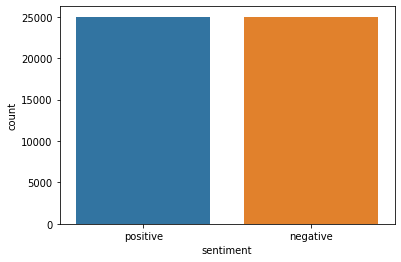

In [7]:
sns.countplot(x='sentiment', data=movie_reviews)

From the output, it is clear that the dataset contains equal number of reviews with positive and negative sentiments.

# Data Preprocessing 

We saw that in the original dataset, the raw reviews contained punctuations and HTML tags. We now define a function that takes a text string as a parameter and then performs processing on the string to remove the punctuation marks and the number, the single characters, multiple white spaces, and the HTML tags from the string. The function, finally, returns the string to its calling function. The following block contains the function definition. 

In [8]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In the preprocess_text function, the first step is to remove the HTML tags. To remove the HTML tags, remove_tags function has been defined. The remove_tags function simply replaces anything between opening and closing <> with an empty space.

Next, in the preprocess_text function, everything is removed except capital and small English letters.

This may result into formation of single characters that carry no meaning. For instance, when we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s". Next, we remove all the single characters and replace it by a space which, in turn, may create multiple spaces in our text. Finally, we remove the multiple spaces from the text corpus.

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

Next, we preprocess the reviews, and store them in a new list as in the following block: 

In [10]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Now, we again check the review with index number 3, (i.e., the fourth review)

In [11]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

From the output, we clearly see that the HTML tags, the punctuations, and the numbers have been removed. We are only left with the English letters.

Next, we convert the sentiments labels "positive" and "negative" into integers. Since we have only two labels, we simply convert them into integers by replacing "positive" with integer value 1 and "negative" with the integer value 0. The following block performs this action:

In [12]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

Finally, we divide the dataset into a training set and a test set. The training set will be used to train our deep learning models, while the test set will be used to evaluate the performance of the models. We use "train_test_split" function defined in the "sklearn.model.selection" module for splitting the dataset into training and test sets. The script in the following block divides the original dataset into 80% for the training set and 20% for the test set.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

We will now write the script for the embedding layer. The embedding layer will convert our textual data into numeric data, and this layer will be used as the first layer for the deep learning models in Keras that we will build.

# Building the Embedding Layer

As a first step, we use the "Tokenizer" class from the "keras.preprocessing.text" module to create a "word-to-index dictionary". In the "word-to-index dictionary", each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key. This method, then, will convert the entire text of a review into a list of numbers. The process of converting a text into a list of integers is done using the code in the following block: 

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
len(X_train)

40000

In [16]:
len(X_train[1])

247

In [17]:
len(X_train[2])

82

We see that X_train contains 40,000 lists where each list contains integers. Each list actually corresponds to the sentences in the training set. We also notice that the sizes of the lists are different. This is because sentences have different lengths. In order to generate input data that is compatible with our deep neural network architecture, we need to make sure that all the sequences have the  same length.

To achieve that objective, we define a parameter "maxlen". We set the maximum size of each list to 100. (Different sizes can be tried out). The lists having size greater than 100 will be truncated to the size of 100. Lists which are shorter in size than 100 are added with 0 at the left-end (left padding) so that their length reaches a value of 100. This process is called padding.

We can implement this preprocessing step in two steps: (1) We create a matrix of zeros, where each row corresponds to a sequence of size 100. (2) We fill in the index of words in each sequence from the right-hand side of the matrix. Thus, if a sequence has a length of 50 and if maxlen is 100, the first 50 elements of the corresponding row will stay zero. "maxlen" is a hyperparameter and should be tuned for optimum model performance.

The code in the following block checks the lists in the training and the test sets, and perform the padding operation on both the datasets. 

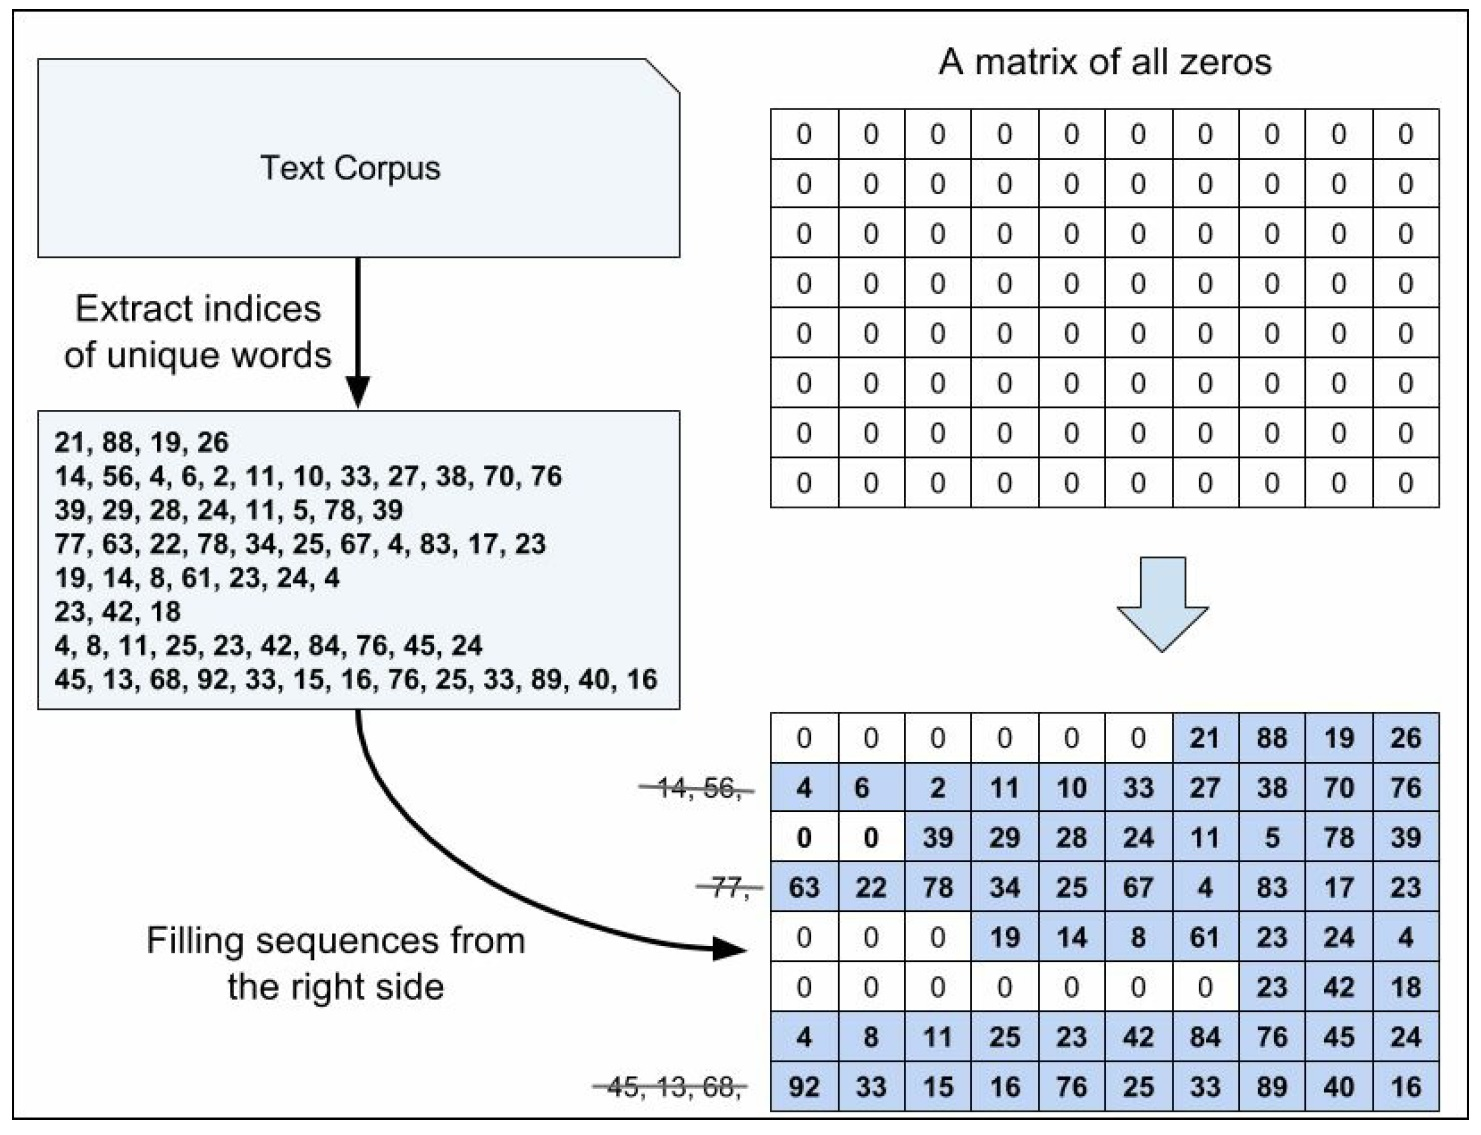

In [18]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)

In [19]:
print(vocab_size)

92547


In [20]:
len(X_train)

40000

In [21]:
len(X_train[1])

100

In [22]:
len(X_train[2])

100

In [23]:
len(X_test[10])

100

In the above blocks, we see that the sizes of all lists in X_train or X_test, are same, i.e., 100. Also, the vocabulary_size variable has a value of 92547, implying that our corpus has 92547 unique words. 

So far, we have generated sequences of the same length. The elements of these sequences are integer numbers that corresponds to the indices of unique words. These word indices can be converted into input features in several different ways. One naive way is to apply one-hot encoding to convert indices into vecor of zeros and ones. Then, each word will be mapped to a vector whose size is the number of unique words in the enite dataset. Given that the number of unique words (size of the vocabulary) can be very large, this will be an unmanageable problem.

A more elegant way is to map each word to a vector of fixed size with real-valued elements (not necesaarily integers). In contrast to the one-hot encoded vectors, we can use finite-sized vectors to represent an infinite number of real numbers. This is the idea behind the so-called embedding, which is a feature-learning technique that we can be utilized to automatically learn the salient features to represent the words in our dataset. Given the number of unique words, we can choose the size of the embedding vectors to be much smaller than the number of unique words (embedding size < unique words) to represent the entire vocabulary as the input features. 

We will now use GloVe embeddings to create our feature matrix. In the following block, we load the GloVe word embeddings (from the file "glove.6B.100d.txt"), and create a dictionary that contains words as the "keys" and their corresponding embedding list as "the values".

In [24]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Finally, we create an embedding matrix where each row number corresponds to the index of the word in the corpus. The matrix has 100 columns where each column contains the GloVe word embeddings for the words in our corpus. The code in the following block perform this task.

In [25]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [26]:
embedding_matrix.shape

(92547, 100)

We see that embedding_matrix contains 92547 rows and 100 columns. The number of rows coresponds to the number of words in our corpus. At this point, we have completed all data preprocesing tasks, and we are ready to create our deep learning models. 

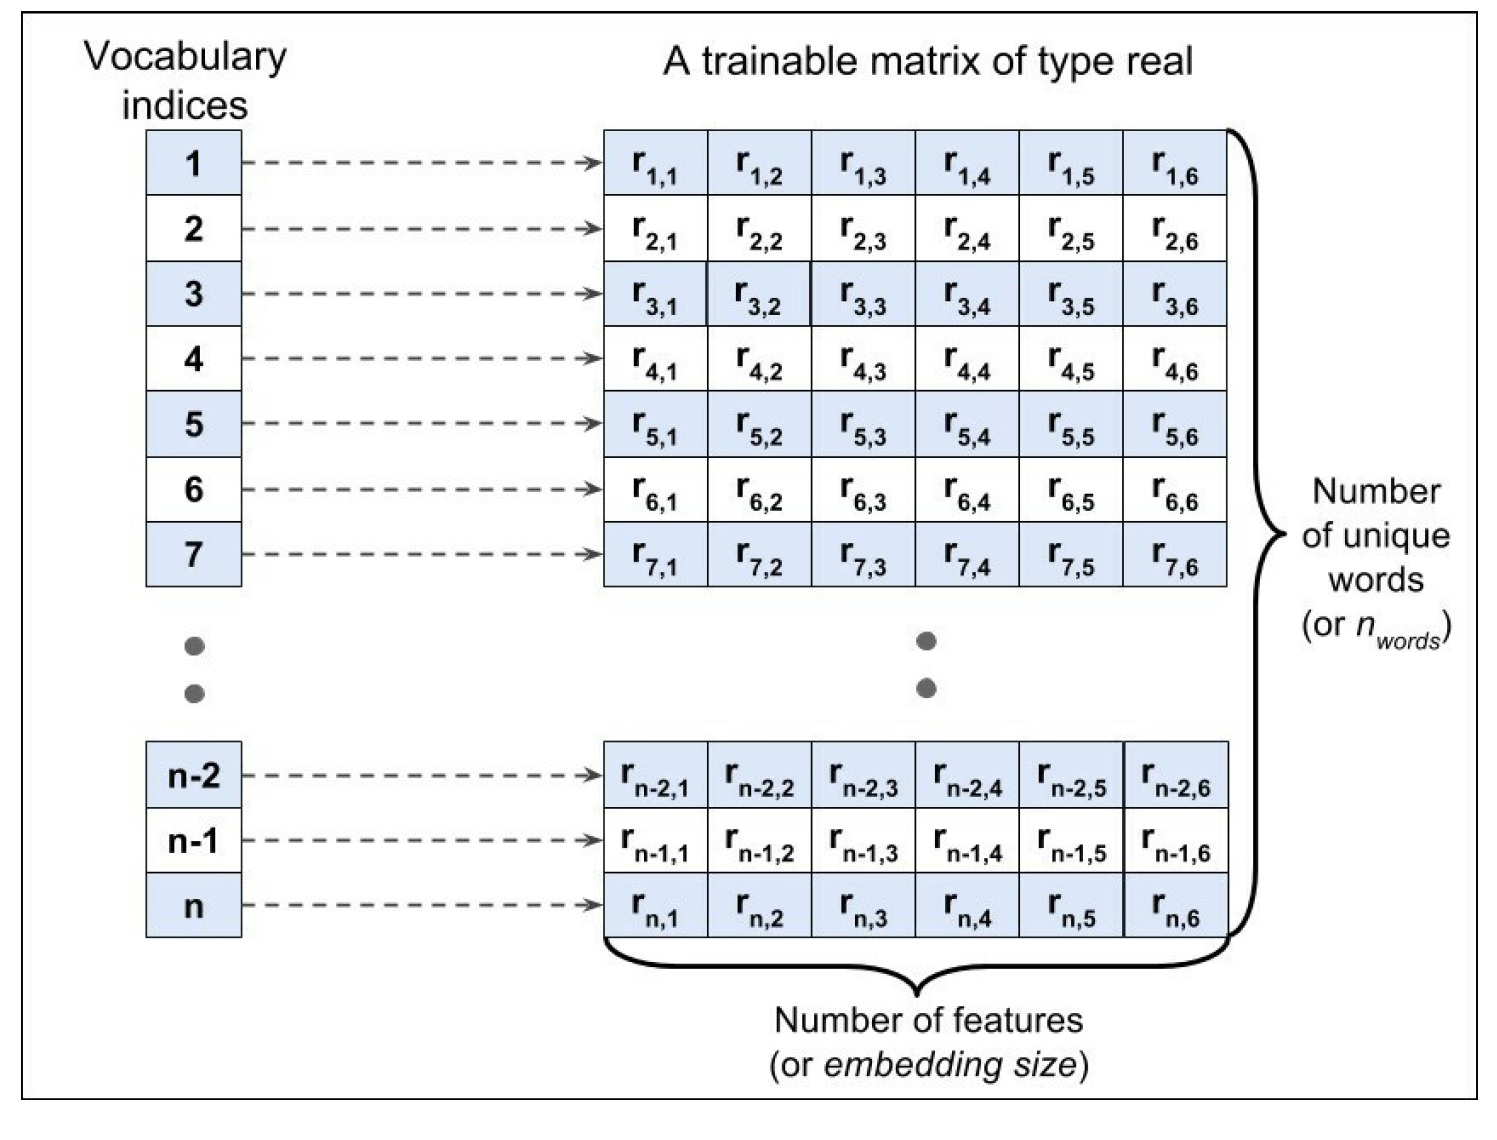

# Deep Neural Network Model

The first model we have developed is a deep neural net,  work. Look at the following script:

In [85]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In above block, we create a Sequential() model. Next, we create our embedding layer. The embedding layer has an input length of 100 (the size of each input list), and the output vector dimension is also 100. The parameter vocab_size (i.e., the vocabulary size) is 92547 words. Since we are not training our own embeddings and using the GloVe embedding, we set trainable to "False", and in the weights attribute we pass our own "embedding matrix".

We, then, add the embedding layer to our model. Next, since we are directly connecting the embedding layer to the densely connected layer, we flatten the embedding layer. Finally, we add a dense layer with the "sigmoid" activation function.

We compile the model using the "adam" optimizer, "binary_crossentropy" as the "loss function", and "accuracy" as the "metrics". We, then, print the summary of the model.

In [86]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [87]:
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
flatten_10 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


Since there are 92547 words in our corpus and each word is represented as a 100-dimensional vector, the number of trainable parameter will be 92547x100 in the embedding layer. In the flattening layer, we simply multiply rows and column. Finally in the dense layer the number of parameters are 10000 (from the flattening layer) and 1 for the bias parameter, for a total of 10001.

We now train the model.

In the following block, we use the "fit" method to train the model on the training dataset. We used 20% of the training data for the purpose of "validation". We used a batch size of 128 and 6 epochs to train the model. 

At the end of the final epoch, the training accuracy and training loss were found to be 0.8379 and 0.3694 respectively. The values for the validation accuracy and validation loss were 0.7319 and 0.5806 respectively. 

In [88]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6023 - acc: 0.6706 - val_loss: 0.5307 - val_acc: 0.7374
Epoch 2/6
250/250 [==============================] - 2s 6ms/step - loss: 0.4913 - acc: 0.7639 - val_loss: 0.5265 - val_acc: 0.7365
Epoch 3/6
250/250 [==============================] - 2s 6ms/step - loss: 0.4542 - acc: 0.7890 - val_loss: 0.5181 - val_acc: 0.7476
Epoch 4/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4342 - acc: 0.8007 - val_loss: 0.5243 - val_acc: 0.7474
Epoch 5/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4231 - acc: 0.8058 - val_loss: 0.5276 - val_acc: 0.7444
Epoch 6/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4043 - acc: 0.8176 - val_loss: 0.5321 - val_acc: 0.7470


To evaluate the performance of the model on the test data, we simply pass the test set to the "evaluate" method of our model.

In [89]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5351 - acc: 0.7467


To check the test accuracy and loss, we execute the following block

In [90]:
print("Test loss:", score[0])
print("Test Accuracy:", score[1])

Test loss: 0.535096287727356
Test Accuracy: 0.7466999888420105


We see that the test test accuracy is 0.7402, while the training accuracy was 0.8158. The difference between the training and the test accuracy is large enough to indicate a possible overfitting of the model on the training dataset. 

In order to understand the behavior of the model more closely, we plot the loss and accuracy differences between the training and the validation datasets. For this purpose, we execute the following blocks. 

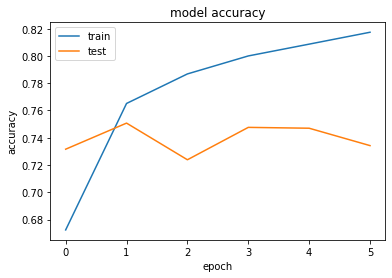

In [37]:
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train','test'], loc='upper left')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','test'])
plt.show()

It is evident that the vaidation accuracy stagnated after the 3rd epoch, while the training accuracy consistently increased with the number of epochs. The large difference in the values of training and validation accuracy clearly indicated a possible model overfitting.

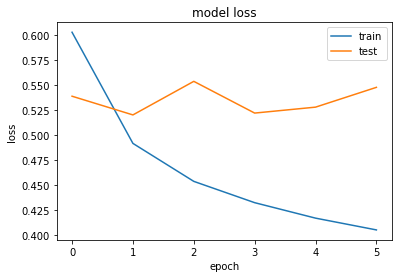

In [38]:
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','test'])
plt.show()

The large difference between the validation loss and the training loss also confirms the possibility of an overfitted model.

# Convolutional Neural Network Model

As our second model, we create a convolutional neural network with one convolutional layer followed by one subsampling (pooling layer). As in the case of the previous model, we have created the embedding in an identical manner before passing its output to the convolutional layer of the model. 

Next, we create a one-dimensional "convolutional layer" with 128 features maps. The kernel size is 5 and the activation function used is "relu". Next, we add a "pooling layer" to reduce feature space. Finally we add a "dense layer" with "sigmoid" activation. 

The code in the following block creates the CNN model.

In [145]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

The CNN model is compiled with the same parameter as our previous deep neural network model.

In [146]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

We now print the summary of model to check the number of parameters in the model, 

In [147]:
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


We now train the model using the "fit" method with batch size of 128, and 6 epochs. To do so, we can use the fit and evaluate methods, respectively.

In [148]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 13s 51ms/step - loss: 0.4983 - acc: 0.7560 - val_loss: 0.3970 - val_acc: 0.8198
Epoch 2/6
250/250 [==============================] - 13s 53ms/step - loss: 0.3674 - acc: 0.8396 - val_loss: 0.3890 - val_acc: 0.8206
Epoch 3/6
250/250 [==============================] - 13s 53ms/step - loss: 0.3193 - acc: 0.8659 - val_loss: 0.3950 - val_acc: 0.8169
Epoch 4/6
250/250 [==============================] - 13s 53ms/step - loss: 0.2773 - acc: 0.8876 - val_loss: 0.3647 - val_acc: 0.8329
Epoch 5/6
250/250 [==============================] - 14s 56ms/step - loss: 0.2429 - acc: 0.9073 - val_loss: 0.3684 - val_acc: 0.8321
Epoch 6/6
250/250 [==============================] - 14s 55ms/step - loss: 0.2147 - acc: 0.9216 - val_loss: 0.3413 - val_acc: 0.8472


At the end of the final epoch (i.e., the 6th epoch), the training loss and training accuracy were found to be 0.2221 and 0.9176 respectively. The validation loss and validation accuracy values were 0.3421 and 0.8525 respectively. 

We evaluate the performance of the model on the test data using the "evaluate" method. 

In [149]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 5ms/step - loss: 0.3420 - acc: 0.8517


In [150]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.3420284688472748
Test Accuracy: 0.8517000079154968


The test accuracy and test loss were observed to be 0.8488 and 0.3417 respectively. The large difference between the training and the test accuracy indicates an overfitted model in this case too.

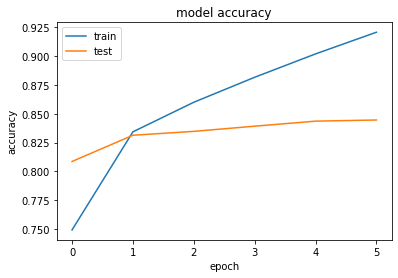

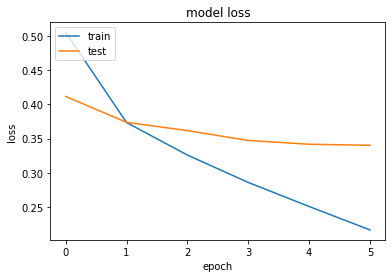

In [46]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

The above plots clearly indicate that our CNN model is still an overfitted one. 

# Long and Short Term Memory Network Model

Recurrent neural network is a type of neural networks that is found to be particularly well-suited to model sequence data. Since text is actually a sequence of words, a recurrent neural network is an automatic choice to solve text-related problems. As our third and final model, we will build a "Long Short Term Memory" (LSTM) network-based model that is a variant of RNN, to solve the movie review-related sentiment classification problem.

To build the LSTM model, we initialize a sequential model, followed by the construction of the "embedding layer". The construction of the embedding layer was identical to that done in our previous two models. Next, we create an LSTM layer with 128 neurons. Different number of neurons may be tried out to check for the most optimum performance of the model. The LSTM layer is followed by a "dense" layer with a "sigmoid" activation function in place. The dense layer is directly connected to the output layer of the model. 

In [205]:
from tensorflow import keras

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
#model.add(LSTM(128))
model.add(keras.layers.LSTM(128, activation='tanh'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

The model is compiled with "adam" as the optimizer, "binary_crossentroy" as the "loss function", and "accuracy" as the metric for evaluation of the model.

In [206]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

The model summary is now printed. 

In [207]:
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


The model is trained with a batch size of 128 and with 6 epoch. The validation dataset was 20% of the total training dataset as in the previous two models. The following block contains the code for training of the model.

In [208]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 48s 193ms/step - loss: 0.5431 - acc: 0.7189 - val_loss: 0.4657 - val_acc: 0.7809
Epoch 2/6
250/250 [==============================] - 50s 200ms/step - loss: 0.4334 - acc: 0.7989 - val_loss: 0.4038 - val_acc: 0.8161
Epoch 3/6
250/250 [==============================] - 49s 195ms/step - loss: 0.3892 - acc: 0.8242 - val_loss: 0.3736 - val_acc: 0.8360
Epoch 4/6
250/250 [==============================] - 53s 210ms/step - loss: 0.3548 - acc: 0.8447 - val_loss: 0.3824 - val_acc: 0.8253
Epoch 5/6
250/250 [==============================] - 56s 222ms/step - loss: 0.3356 - acc: 0.8513 - val_loss: 0.3485 - val_acc: 0.8460
Epoch 6/6
250/250 [==============================] - 48s 194ms/step - loss: 0.3160 - acc: 0.8637 - val_loss: 0.3382 - val_acc: 0.8562


At the end of the final epoch, the training loss and the training accuracy were 0,2206 and 0.9117 respectively. The validation loss and validation training values were 0.3513 and 0.8580 respectively. We can see that this time, the difference between the training accuracy and validation accuracy is not very large. Looks like that the model is no longer suffering from the overfitting problem. 

We also evaluated the performance of the model on the test dataset using the "evaluate" function.

In [209]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 11s 35ms/step - loss: 0.3385 - acc: 0.8500


In [210]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.33850163221359253
Test Accuracy: 0.8500000238418579


The loss and the accuracy of the model on the test data were found to be 0.3446 and 0.8604 resectively. It is clearly that the difference between the training and test accuracy values is low. While te training accuracy of the model was 0.9117, the test accuracy was found to be 0.8604. The model clearly does not suffer from the overfitting problem any further.  

We plotted the training and validation loss and accuracy plots to study the behvaior of the training and the validation process. 

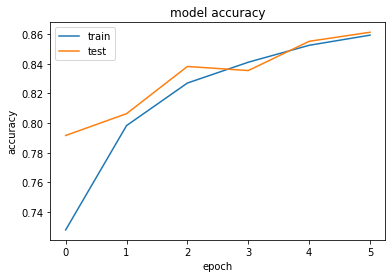

In [77]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

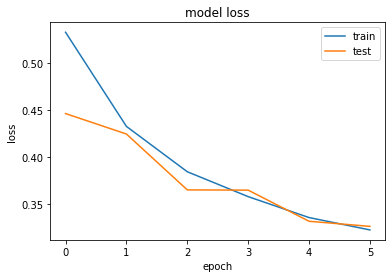

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()

It is evident from the above plots that the training and validation loss and the training and validation accuracy have converged very closely at the completion of the final epoch giving a very reliable evidence of absence of overfitting in the model. Based on our analysis, we conclude that among the three models that we have constructed for carrying out sentiment analysis on the movie review data, the LSTM model turned out to be the best model. 

# Making Pedictions Using the Model

As a final task, we now make predictions on a single instance or single sentiment using oure model. For this purpose, we retrieve any review from our corpus and then predict its category using our model. 

Let's first randomly select any review from our corpus. Suppose, we selected the review with index number 57. 

In [79]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


It is amply clear that the review is a negtaive one. 

To predict the sentiment of this review, we, first, need to convert it into a numeric form. We can do so using the "tokenizer" that we created during the  "word embedding". The "text_to_sequences" method will convert the sentence into its numeric value. 

Next, we need to pad our input sequence as we did for our corpus earlier. Finally, we use the "predict" method of our model on the processed input sequence. The following block of code performs all these operations. 

In [80]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.27116966]], dtype=float32)

It may be remembered that the positive reviews were mapped to 1, while the negative ones being mapped to 0. However, the activation function "sigmoid" predicts floating value between 0 and 1. If the numeric value corresponding to a review is found to be less than 0.5, the sentiment expressed by the review  is considered to be negative. A value that is greater than 0.5, on the other hand, indicates a positive sentiment. The sentiment value for the review that we considered was found to be 0.1283. Hence, the model will recognize the review as a negative sentiment, and the model's prediction is absolutely correct.

# Convolutional Neural Network with Dropout Regularization

We have used dropout regularization on the overfitted CNN mpodel to eliminate the overfitting. For this purpose, we have added a dropout layer after the convolutional layer and another dropout layer after the Global MaxPooling layer. In both these layers we applied a dropout percenateg of 0.27, so that 27% of the nodes in the layers are put off randomly so as to prevent the network from learning deeply from the extrated features. We study the behavior of the training and validation accuracy after the regularization of the model the dropout technique. 

In [265]:
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.27))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.27))
model.add(Dense(1, activation='sigmoid'))

In [266]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [267]:
print(model.summary())

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 100, 100)          9254700   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 96, 128)           64128     
_________________________________________________________________
dropout_18 (Dropout)         (None, 96, 128)           0         
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 128)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
______________________________________

In [268]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 18s 73ms/step - loss: 0.5420 - acc: 0.7241 - val_loss: 0.4331 - val_acc: 0.8116
Epoch 2/6
250/250 [==============================] - 19s 74ms/step - loss: 0.4152 - acc: 0.8093 - val_loss: 0.4070 - val_acc: 0.8164
Epoch 3/6
250/250 [==============================] - 19s 76ms/step - loss: 0.3803 - acc: 0.8283 - val_loss: 0.3977 - val_acc: 0.8174
Epoch 4/6
250/250 [==============================] - 19s 76ms/step - loss: 0.3498 - acc: 0.8448 - val_loss: 0.3726 - val_acc: 0.8365
Epoch 5/6
250/250 [==============================] - 19s 75ms/step - loss: 0.3351 - acc: 0.8527 - val_loss: 0.3614 - val_acc: 0.8435
Epoch 6/6
250/250 [==============================] - 19s 77ms/step - loss: 0.3139 - acc: 0.8640 - val_loss: 0.3539 - val_acc: 0.8444


In [269]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 5ms/step - loss: 0.3504 - acc: 0.8450


In [270]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.35037708282470703
Test Accuracy: 0.8450000286102295


We see that the test accuracy of the regularized CNN model is almost the same as that of the LSTM model. Moroever, there is a small gap between the training and the validation accuracy.  This indicates clearly that the model is now free from any overfitting problem. 

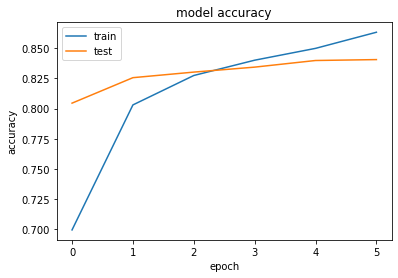

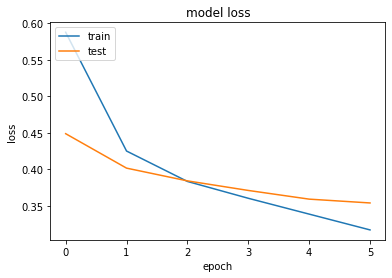

In [70]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()